In [2]:
%pip install imblearn
%pip install imbalanced-learn


   ---------------------------------------- 0/2 [imbalanced-learn]
   ---------------------------------------- 0/2 [imbalanced-learn]
   ---------------------------------------- 0/2 [imbalanced-learn]
   ---------------------------------------- 0/2 [imbalanced-learn]
   ---------------------------------------- 0/2 [imbalanced-learn]
   ---------------------------------------- 0/2 [imbalanced-learn]
   ---------------------------------------- 0/2 [imbalanced-learn]
   ---------------------------------------- 0/2 [imbalanced-learn]
   ---------------------------------------- 0/2 [imbalanced-learn]
   ---------------------------------------- 0/2 [imbalanced-learn]
   ---------------------------------------- 0/2 [imbalanced-learn]
   ---------------------------------------- 2/2 [imblearn]

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_score, recall_score,
                             f1_score, roc_curve, roc_auc_score)
from imblearn.over_sampling import SMOTE
from collections import Counter
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load Dataset

In [4]:
df = pd.read_csv('data_banjir_engineered.csv')

print("Dataset Info:")
print(f"Shape: {df.shape}")
print(f"\nTarget Distribution (Before SMOTE):")
print(df['banjir'].value_counts())
print(f"\nClass Balance:")
print(df['banjir'].value_counts(normalize=True) * 100)
print(f"\nColumns: {list(df.columns)}")

Dataset Info:
Shape: (10980, 22)

Target Distribution (Before SMOTE):
banjir
0    10135
1      845
Name: count, dtype: int64

Class Balance:
banjir
0    92.304189
1     7.695811
Name: proportion, dtype: float64

Columns: ['kabupaten_kota', 'kecamatan', 'avg_rainfall', 'max_rainfall', 'avg_temperature', 'elevation', 'landcover_class', 'ndvi', 'slope', 'soil_moisture', 'year', 'month', 'banjir', 'lat', 'long', 'jumlah_penduduk', 'rainfall_intensity', 'is_rainy_season', 'elevation_slope_ratio', 'vegetation_moisture', 'population_density_proxy', 'extreme_rainfall']


## 2. Data Preparation

In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['landcover_encoded'] = le.fit_transform(df['landcover_class'])

print(f"Landcover classes encoded:")
for i, label in enumerate(le.classes_):
    print(f"  {label}: {i}")

numerical_features = ['avg_rainfall', 'max_rainfall', 'avg_temperature',
                      'elevation', 'ndvi', 'slope', 'soil_moisture', 'jumlah_penduduk',
                      'rainfall_intensity', 'elevation_slope_ratio',
                      'vegetation_moisture', 'population_density_proxy']

categorical_features = ['month', 'is_rainy_season', 'extreme_rainfall', 'landcover_encoded']

feature_columns = numerical_features + categorical_features

X = df[feature_columns]
y = df['banjir']

print(f"\nFeatures selected: {len(feature_columns)}")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

Landcover classes encoded:
  Built-up: 0
  Cropland: 1
  Permanent water bodies: 2
  Tree cover: 3

Features selected: 16
X shape: (10980, 16)
y shape: (10980,)


## 3. Train-Test Split (BEFORE SMOTE)

**PENTING:** Split dilakukan SEBELUM SMOTE untuk menghindari data leakage!

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("=" * 70)
print("TRAIN-TEST SPLIT (BEFORE SMOTE)")
print("=" * 70)

print(f"\nX_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

print(f"\nTrain class distribution (BEFORE SMOTE):")
print(y_train.value_counts())
print(f"\nTrain class balance (BEFORE SMOTE):")
print(y_train.value_counts(normalize=True) * 100)

print(f"\nTest class distribution (UNCHANGED):")
print(y_test.value_counts())
print(f"\nTest class balance (UNCHANGED):")
print(y_test.value_counts(normalize=True) * 100)

TRAIN-TEST SPLIT (BEFORE SMOTE)

X_train: (8784, 16)
X_test: (2196, 16)
y_train: (8784,)
y_test: (2196,)

Train class distribution (BEFORE SMOTE):
banjir
0    8108
1     676
Name: count, dtype: int64

Train class balance (BEFORE SMOTE):
banjir
0    92.304189
1     7.695811
Name: proportion, dtype: float64

Test class distribution (UNCHANGED):
banjir
0    2027
1     169
Name: count, dtype: int64

Test class balance (UNCHANGED):
banjir
0    92.304189
1     7.695811
Name: proportion, dtype: float64


## 4. Apply SMOTE (ONLY on Training Data)

SMOTE hanya diterapkan pada data training untuk menghindari data leakage. Data test TIDAK disentuh sama sekali!

In [7]:
print("=" * 70)
print("APPLYING SMOTE ON TRAINING DATA ONLY")
print("=" * 70)

print(f"\nClass distribution BEFORE SMOTE:")
print(f"  Class 0: {(y_train == 0).sum()}")
print(f"  Class 1: {(y_train == 1).sum()}")
print(f"  Imbalance Ratio: {(y_train == 0).sum() / (y_train == 1).sum():.2f}:1")

smote = SMOTE(random_state=42, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"\nClass distribution AFTER SMOTE:")
print(f"  Class 0: {(y_train_smote == 0).sum()}")
print(f"  Class 1: {(y_train_smote == 1).sum()}")
print(f"  Balance Ratio: {(y_train_smote == 0).sum() / (y_train_smote == 1).sum():.2f}:1")

print(f"\nTraining set size change:")
print(f"  Before SMOTE: {X_train.shape[0]:,} samples")
print(f"  After SMOTE: {X_train_smote.shape[0]:,} samples")
print(f"  Synthetic samples generated: {X_train_smote.shape[0] - X_train.shape[0]:,}")

print(f"\nTest set (UNCHANGED):")
print(f"  X_test: {X_test.shape}")
print(f"  y_test distribution: {Counter(y_test)}")
print(f"  ✓ Test data is NOT affected by SMOTE!")

APPLYING SMOTE ON TRAINING DATA ONLY

Class distribution BEFORE SMOTE:
  Class 0: 8108
  Class 1: 676
  Imbalance Ratio: 11.99:1

Class distribution AFTER SMOTE:
  Class 0: 8108
  Class 1: 8108
  Balance Ratio: 1.00:1

Training set size change:
  Before SMOTE: 8,784 samples
  After SMOTE: 16,216 samples
  Synthetic samples generated: 7,432

Test set (UNCHANGED):
  X_test: (2196, 16)
  y_test distribution: Counter({0: 2027, 1: 169})
  ✓ Test data is NOT affected by SMOTE!


## 5. Visualize SMOTE Effect

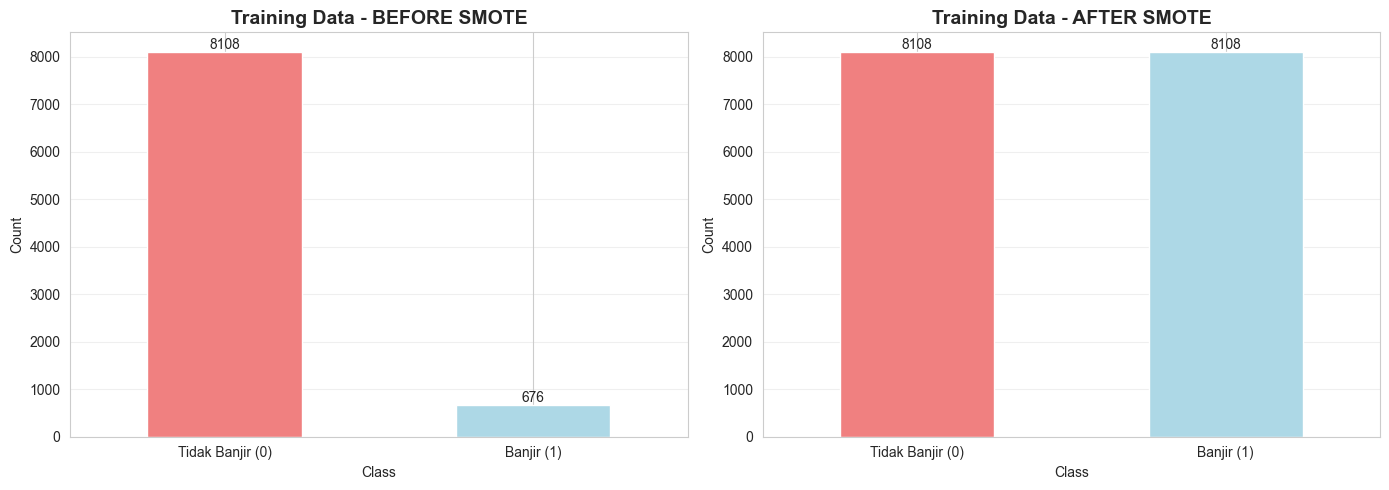

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

y_train.value_counts().plot(kind='bar', ax=axes[0], color=['lightcoral', 'lightblue'])
axes[0].set_title('Training Data - BEFORE SMOTE', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Tidak Banjir (0)', 'Banjir (1)'], rotation=0)
axes[0].grid(axis='y', alpha=0.3)
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%d')

pd.Series(y_train_smote).value_counts().plot(kind='bar', ax=axes[1], color=['lightcoral', 'lightblue'])
axes[1].set_title('Training Data - AFTER SMOTE', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(['Tidak Banjir (0)', 'Banjir (1)'], rotation=0)
axes[1].grid(axis='y', alpha=0.3)
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%d')

plt.tight_layout()
plt.show()

## 6. Verify Data Integrity

In [9]:
print("=" * 70)
print("DATA INTEGRITY CHECK")
print("=" * 70)

print(f"\n✓ Train-Test Split Verification:")
print(f"  Original dataset size: {len(df):,}")
print(f"  Train size (before SMOTE): {len(X_train):,} ({len(X_train)/len(df)*100:.1f}%)")
print(f"  Test size: {len(X_test):,} ({len(X_test)/len(df)*100:.1f}%)")
print(f"  Train size (after SMOTE): {len(X_train_smote):,}")
print(f"  Test size (unchanged): {len(X_test):,}")

print(f"\n✓ No Data Leakage:")
print(f"  Test set remains original: {len(X_test) == len(y_test)}")
print(f"  Test class distribution unchanged: {Counter(y_test)}")

print(f"\n✓ SMOTE Applied Correctly:")
print(f"  SMOTE only on training data: {len(X_train_smote) > len(X_train)}")
print(f"  Classes balanced in training: {abs((y_train_smote == 0).sum() - (y_train_smote == 1).sum()) <= 1}")

print(f"\n✓ Feature Consistency:")
print(f"  Training features: {X_train_smote.shape[1]}")
print(f"  Test features: {X_test.shape[1]}")
print(f"  Features match: {X_train_smote.shape[1] == X_test.shape[1]}")

DATA INTEGRITY CHECK

✓ Train-Test Split Verification:
  Original dataset size: 10,980
  Train size (before SMOTE): 8,784 (80.0%)
  Test size: 2,196 (20.0%)
  Train size (after SMOTE): 16,216
  Test size (unchanged): 2,196

✓ No Data Leakage:
  Test set remains original: True
  Test class distribution unchanged: Counter({0: 2027, 1: 169})

✓ SMOTE Applied Correctly:
  SMOTE only on training data: True
  Classes balanced in training: True

✓ Feature Consistency:
  Training features: 16
  Test features: 16
  Features match: True


## 7. Save SMOTE Data for Modeling

In [10]:
train_smote_df = pd.DataFrame(X_train_smote, columns=feature_columns)
train_smote_df['banjir'] = y_train_smote.values

test_df = pd.DataFrame(X_test, columns=feature_columns)
test_df['banjir'] = y_test.values

train_smote_df.to_csv('data_train_smote.csv', index=False)
test_df.to_csv('data_test_original.csv', index=False)

print("=" * 70)
print("FILES SAVED")
print("=" * 70)
print("\n✓ data_train_smote.csv")
print(f"  - Size: {train_smote_df.shape}")
print(f"  - Class balance: {Counter(train_smote_df['banjir'])}")
print(f"  - Use this for TRAINING models")

print("\n✓ data_test_original.csv")
print(f"  - Size: {test_df.shape}")
print(f"  - Class balance: {Counter(test_df['banjir'])}")
print(f"  - Use this for TESTING models")

print("\n" + "=" * 70)
print("SMOTE PROCESS COMPLETED SUCCESSFULLY!")
print("=" * 70)
print("\nKey Points:")
print("  ✓ SMOTE applied ONLY to training data")
print("  ✓ Test data remains UNTOUCHED (no data leakage)")
print("  ✓ Training classes are now balanced")
print("  ✓ Ready for model training and evaluation")

FILES SAVED

✓ data_train_smote.csv
  - Size: (16216, 17)
  - Class balance: Counter({0: 8108, 1: 8108})
  - Use this for TRAINING models

✓ data_test_original.csv
  - Size: (2196, 17)
  - Class balance: Counter({0: 2027, 1: 169})
  - Use this for TESTING models

SMOTE PROCESS COMPLETED SUCCESSFULLY!

Key Points:
  ✓ SMOTE applied ONLY to training data
  ✓ Test data remains UNTOUCHED (no data leakage)
  ✓ Training classes are now balanced
  ✓ Ready for model training and evaluation


## 8. Train Decision Tree on SMOTE Data

Melatih Decision Tree dengan data yang sudah di-balance menggunakan SMOTE

In [11]:
dt_smote = DecisionTreeClassifier(random_state=42)

dt_smote.fit(X_train_smote, y_train_smote)

y_pred_train_smote = dt_smote.predict(X_train_smote)
y_pred_test_smote = dt_smote.predict(X_test)

print("=" * 70)
print("DECISION TREE WITH SMOTE - BASELINE")
print("=" * 70)

print(f"\nTraining Performance:")
print(f"  Accuracy: {accuracy_score(y_train_smote, y_pred_train_smote):.4f}")

print(f"\nTest Performance:")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_test_smote):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_test_smote):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_test_smote):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_test_smote):.4f}")

print(f"\nTree Structure:")
print(f"  Depth: {dt_smote.get_depth()}")
print(f"  Leaves: {dt_smote.get_n_leaves()}")

DECISION TREE WITH SMOTE - BASELINE

Training Performance:
  Accuracy: 1.0000

Test Performance:
  Accuracy: 0.8584
  Precision: 0.2695
  Recall: 0.4911
  F1-Score: 0.3480

Tree Structure:
  Depth: 29
  Leaves: 1178


## 9. Evaluation Metrics

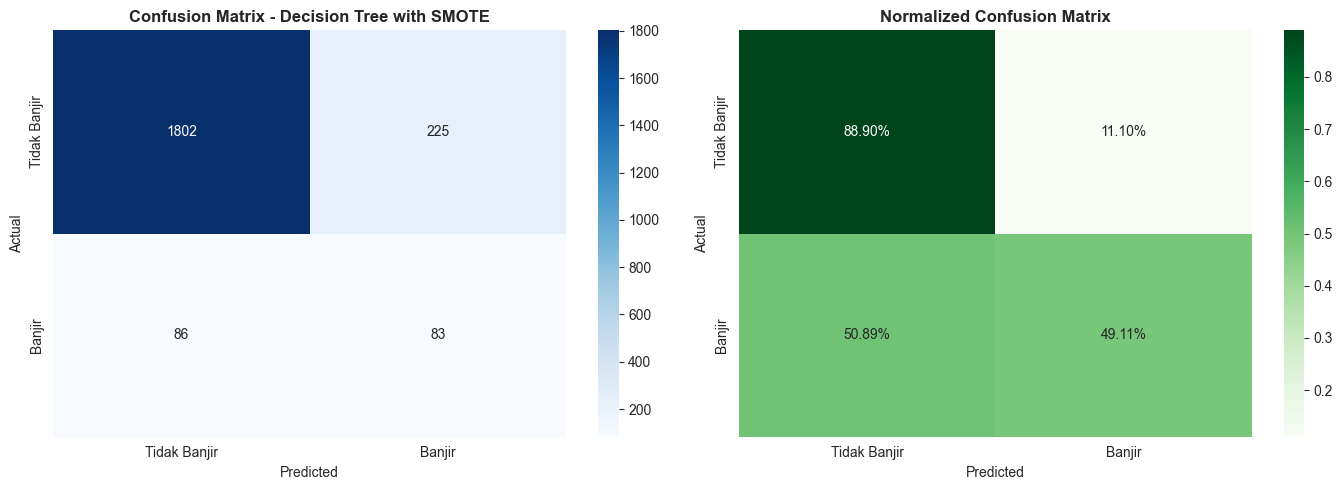


Classification Report:
              precision    recall  f1-score   support

Tidak Banjir       0.95      0.89      0.92      2027
      Banjir       0.27      0.49      0.35       169

    accuracy                           0.86      2196
   macro avg       0.61      0.69      0.63      2196
weighted avg       0.90      0.86      0.88      2196



In [12]:
cm = confusion_matrix(y_test, y_pred_test_smote)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Tidak Banjir', 'Banjir'],
            yticklabels=['Tidak Banjir', 'Banjir'],
            ax=axes[0])
axes[0].set_title('Confusion Matrix - Decision Tree with SMOTE', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens',
            xticklabels=['Tidak Banjir', 'Banjir'],
            yticklabels=['Tidak Banjir', 'Banjir'],
            ax=axes[1])
axes[1].set_title('Normalized Confusion Matrix', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

print("\nClassification Report:")
print("=" * 70)
print(classification_report(y_test, y_pred_test_smote,
                          target_names=['Tidak Banjir', 'Banjir']))

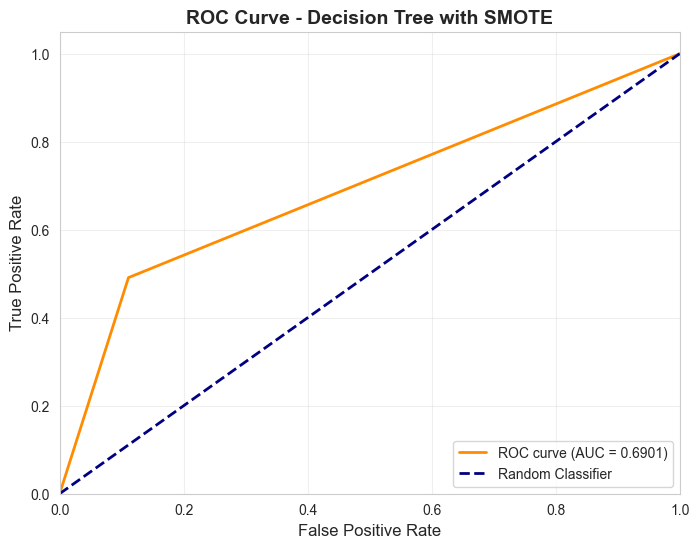

AUC-ROC Score: 0.6901


In [13]:
y_pred_proba_smote = dt_smote.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_smote)
roc_auc = roc_auc_score(y_test, y_pred_proba_smote)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Decision Tree with SMOTE', fontweight='bold', fontsize=14)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print(f"AUC-ROC Score: {roc_auc:.4f}")

## 10. Feature Importance

Feature Importance (Top 15):
avg_rainfall                       : 0.1932
month                              : 0.1332
jumlah_penduduk                    : 0.0930
max_rainfall                       : 0.0917
soil_moisture                      : 0.0788
rainfall_intensity                 : 0.0689
avg_temperature                    : 0.0679
ndvi                               : 0.0551
population_density_proxy           : 0.0504
vegetation_moisture                : 0.0395
is_rainy_season                    : 0.0363
slope                              : 0.0255
elevation_slope_ratio              : 0.0240
elevation                          : 0.0227
extreme_rainfall                   : 0.0154


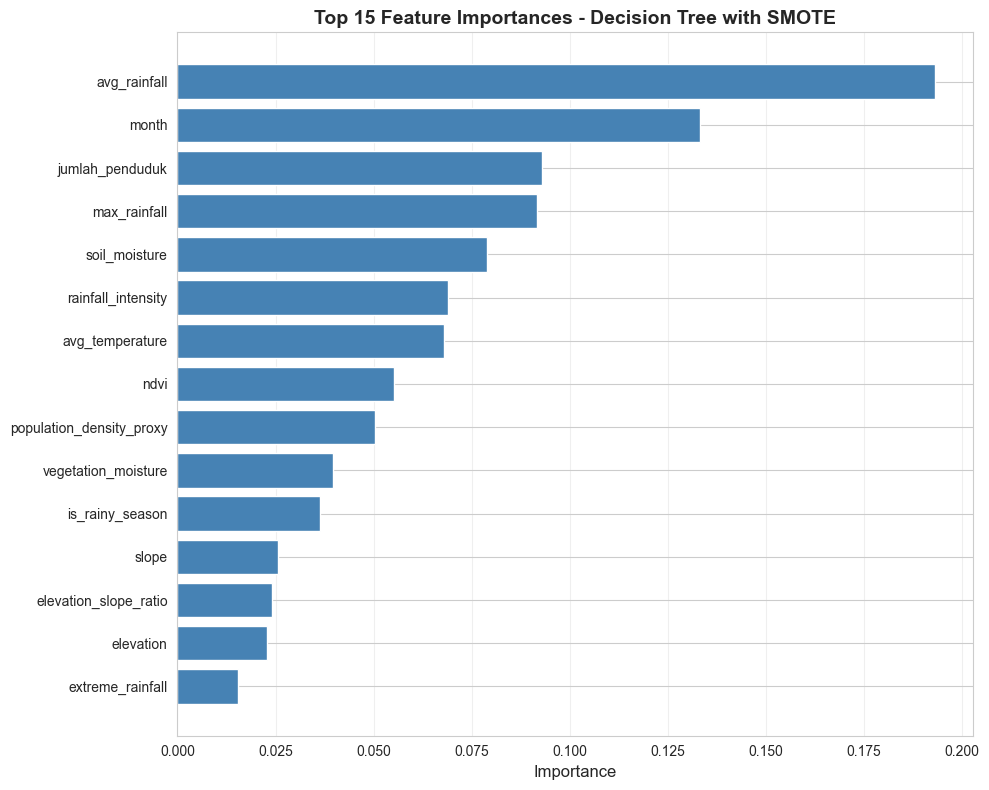

In [14]:
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': dt_smote.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance (Top 15):")
print("=" * 70)
for idx, row in feature_importance.head(15).iterrows():
    print(f"{row['feature']:35s}: {row['importance']:.4f}")

plt.figure(figsize=(10, 8))
top_15 = feature_importance.head(15)
plt.barh(range(len(top_15)), top_15['importance'], color='steelblue')
plt.yticks(range(len(top_15)), top_15['feature'])
plt.xlabel('Importance', fontsize=12)
plt.title('Top 15 Feature Importances - Decision Tree with SMOTE', fontweight='bold', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 11. Hyperparameter Tuning with GridSearchCV

In [15]:
param_grid = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 10, 20, 50],
    'min_samples_leaf': [1, 5, 10, 20],
    'criterion': ['gini', 'entropy']
}

dt_grid_smote = DecisionTreeClassifier(random_state=42)

grid_search_smote = GridSearchCV(
    dt_grid_smote,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

print("Running GridSearchCV on SMOTE data...")
print("This may take a few minutes...")
grid_search_smote.fit(X_train_smote, y_train_smote)

print("\nBest Parameters:")
print("=" * 70)
for param, value in grid_search_smote.best_params_.items():
    print(f"{param:25s}: {value}")

print(f"\nBest CV Score (F1): {grid_search_smote.best_score_:.4f}")

dt_best_smote = grid_search_smote.best_estimator_
y_pred_best_smote = dt_best_smote.predict(X_test)

print(f"\nBest Model Test Performance:")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_best_smote):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_best_smote):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_best_smote):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_best_smote):.4f}")
print(f"  AUC-ROC: {roc_auc_score(y_test, dt_best_smote.predict_proba(X_test)[:, 1]):.4f}")

print(f"\nTree Structure:")
print(f"  Depth: {dt_best_smote.get_depth()}")
print(f"  Leaves: {dt_best_smote.get_n_leaves()}")

Running GridSearchCV on SMOTE data...
This may take a few minutes...
Fitting 5 folds for each of 160 candidates, totalling 800 fits

Best Parameters:
criterion                : entropy
max_depth                : None
min_samples_leaf         : 1
min_samples_split        : 2

Best CV Score (F1): 0.9053

Best Model Test Performance:
  Accuracy: 0.8711
  Precision: 0.2889
  Recall: 0.4615
  F1-Score: 0.3554
  AUC-ROC: 0.6834

Tree Structure:
  Depth: 28
  Leaves: 1064


## 12. Compare Models: Baseline vs Tuned

MODEL COMPARISON: BASELINE vs HYPERPARAMETER TUNED (with SMOTE)

           Baseline     Tuned  Improvement
Accuracy   0.858379  0.871129     0.012750
Precision  0.269481  0.288889     0.019408
Recall     0.491124  0.461538    -0.029586
F1-Score   0.348008  0.355353     0.007345
AUC-ROC    0.690061  0.683409    -0.006653


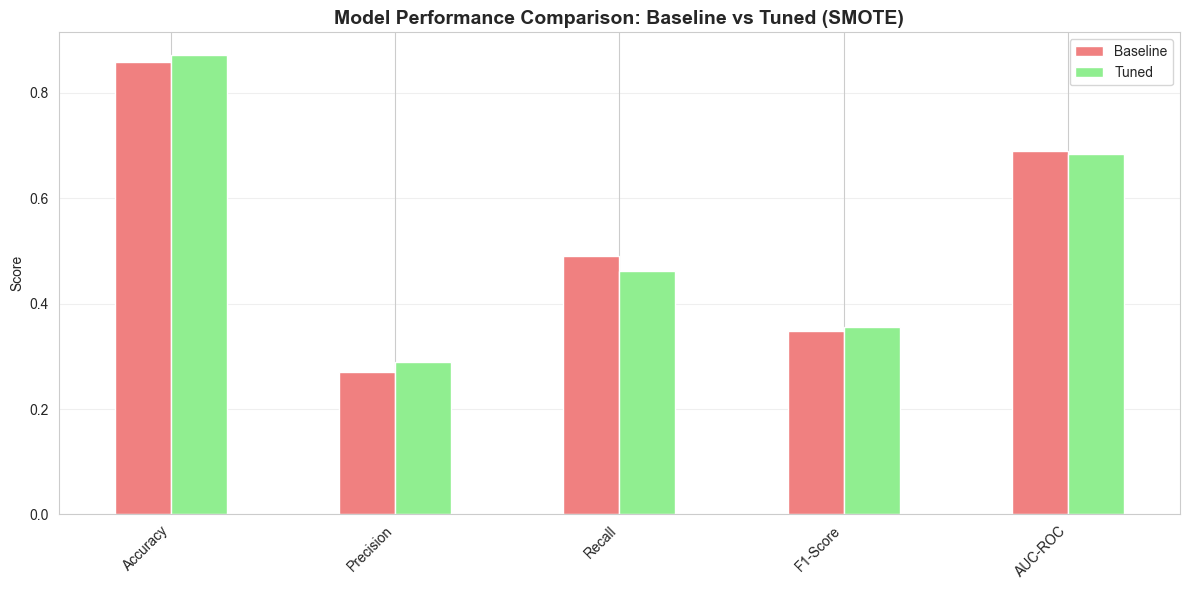

In [16]:
print("=" * 80)
print("MODEL COMPARISON: BASELINE vs HYPERPARAMETER TUNED (with SMOTE)")
print("=" * 80)

baseline_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_test_smote),
    'Precision': precision_score(y_test, y_pred_test_smote),
    'Recall': recall_score(y_test, y_pred_test_smote),
    'F1-Score': f1_score(y_test, y_pred_test_smote),
    'AUC-ROC': roc_auc_score(y_test, dt_smote.predict_proba(X_test)[:, 1])
}

tuned_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_best_smote),
    'Precision': precision_score(y_test, y_pred_best_smote),
    'Recall': recall_score(y_test, y_pred_best_smote),
    'F1-Score': f1_score(y_test, y_pred_best_smote),
    'AUC-ROC': roc_auc_score(y_test, dt_best_smote.predict_proba(X_test)[:, 1])
}

comparison_df = pd.DataFrame({
    'Baseline': baseline_metrics,
    'Tuned': tuned_metrics,
    'Improvement': {k: tuned_metrics[k] - baseline_metrics[k] for k in baseline_metrics}
})

print("\n" + comparison_df.to_string())

fig, ax = plt.subplots(figsize=(12, 6))
comparison_df[['Baseline', 'Tuned']].plot(kind='bar', ax=ax, color=['lightcoral', 'lightgreen'])
ax.set_title('Model Performance Comparison: Baseline vs Tuned (SMOTE)', fontweight='bold', fontsize=14)
ax.set_ylabel('Score')
ax.set_xticklabels(comparison_df.index, rotation=45, ha='right')
ax.legend(['Baseline', 'Tuned'])
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 13. Visualize Best Model Tree

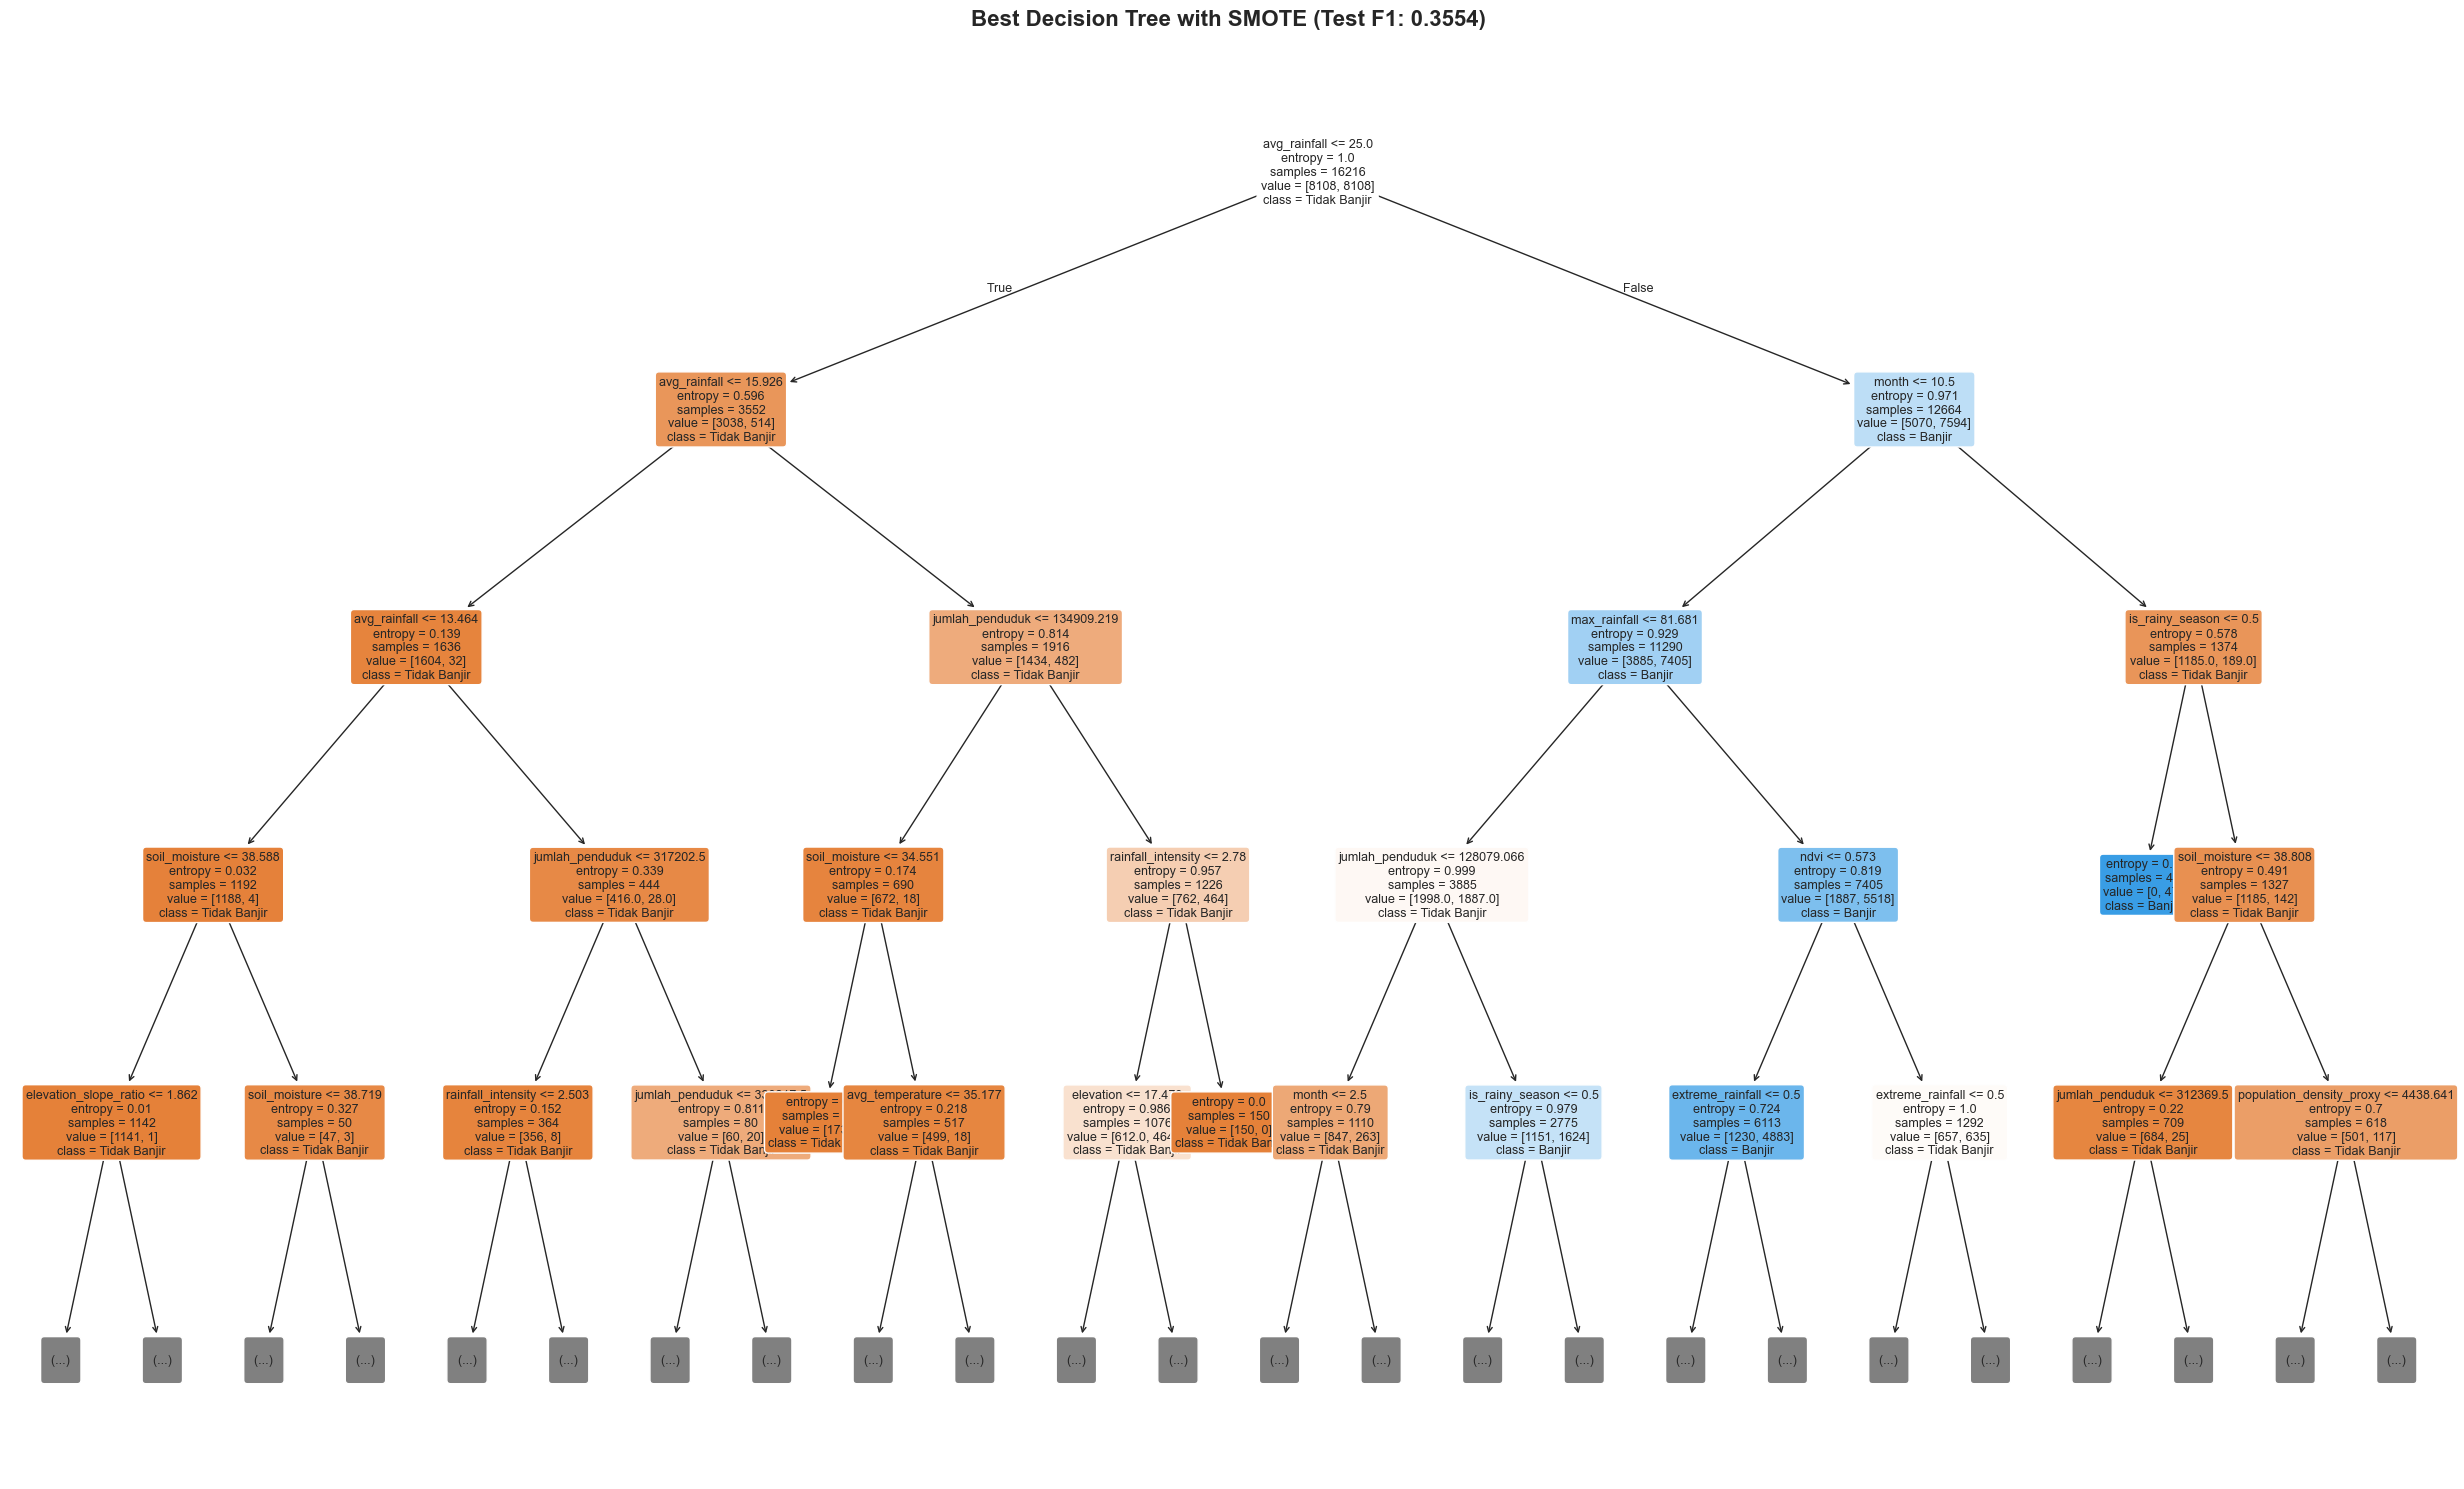

Tree visualization saved to: decision_tree_smote_visualization.png


In [17]:
plt.figure(figsize=(25, 15))
plot_tree(dt_best_smote,
          feature_names=feature_columns,
          class_names=['Tidak Banjir', 'Banjir'],
          filled=True,
          rounded=True,
          fontsize=9,
          max_depth=4)
plt.title(f'Best Decision Tree with SMOTE (Test F1: {f1_score(y_test, y_pred_best_smote):.4f})',
          fontweight='bold', fontsize=16, pad=20)
plt.tight_layout()
plt.savefig('decision_tree_smote_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("Tree visualization saved to: decision_tree_smote_visualization.png")

## 14. Extract Decision Rules

In [18]:
tree_rules = export_text(dt_best_smote, feature_names=feature_columns)

print("Decision Tree Rules (Best Model with SMOTE):")
print("=" * 80)
print(tree_rules[:2000])
print("\n... (truncated for display, full tree saved to file)")

with open('decision_tree_smote_rules.txt', 'w') as f:
    f.write("Decision Tree Rules - Flood Prediction with SMOTE\n")
    f.write("=" * 80 + "\n\n")
    f.write(f"Model Parameters:\n")
    f.write(f"  Criterion: {dt_best_smote.criterion}\n")
    f.write(f"  Max Depth: {dt_best_smote.max_depth}\n")
    f.write(f"  Min Samples Split: {dt_best_smote.min_samples_split}\n")
    f.write(f"  Min Samples Leaf: {dt_best_smote.min_samples_leaf}\n")
    f.write(f"  Tree Depth: {dt_best_smote.get_depth()}\n")
    f.write(f"  Number of Leaves: {dt_best_smote.get_n_leaves()}\n\n")
    f.write(f"Performance Metrics:\n")
    f.write(f"  Test Accuracy: {accuracy_score(y_test, y_pred_best_smote):.4f}\n")
    f.write(f"  Test Precision: {precision_score(y_test, y_pred_best_smote):.4f}\n")
    f.write(f"  Test Recall: {recall_score(y_test, y_pred_best_smote):.4f}\n")
    f.write(f"  Test F1-Score: {f1_score(y_test, y_pred_best_smote):.4f}\n")
    f.write(f"  Test AUC-ROC: {roc_auc_score(y_test, dt_best_smote.predict_proba(X_test)[:, 1]):.4f}\n\n")
    f.write("=" * 80 + "\n\n")
    f.write(tree_rules)

print("\nFull rules saved to: decision_tree_smote_rules.txt")

Decision Tree Rules (Best Model with SMOTE):
|--- avg_rainfall <= 25.00
|   |--- avg_rainfall <= 15.93
|   |   |--- avg_rainfall <= 13.46
|   |   |   |--- soil_moisture <= 38.59
|   |   |   |   |--- elevation_slope_ratio <= 1.86
|   |   |   |   |   |--- month <= 6.50
|   |   |   |   |   |   |--- vegetation_moisture <= 15.37
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- vegetation_moisture >  15.37
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- month >  6.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- elevation_slope_ratio >  1.86
|   |   |   |   |   |--- class: 0
|   |   |   |--- soil_moisture >  38.59
|   |   |   |   |--- soil_moisture <= 38.72
|   |   |   |   |   |--- jumlah_penduduk <= 276928.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- jumlah_penduduk >  276928.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- soil_moisture >  38.72
|   |   |   |   |   |--- class: 0
|   |   |--- avg_rainfal

## 15. Final Summary

In [19]:
print("=" * 80)
print("FINAL SUMMARY - DECISION TREE WITH SMOTE")
print("=" * 80)

print("\n1. DATA PREPARATION:")
print(f"   ✓ Original dataset: {len(df):,} samples")
print(f"   ✓ Train-test split: {len(X_train):,} / {len(X_test):,} (80/20)")
print(f"   ✓ SMOTE applied on training data only")
print(f"   ✓ Training data after SMOTE: {len(X_train_smote):,} samples (balanced)")
print(f"   ✓ Test data: {len(X_test):,} samples (original distribution)")

print("\n2. MODEL CONFIGURATION:")
print(f"   ✓ Algorithm: Decision Tree Classifier")
print(f"   ✓ Best Criterion: {dt_best_smote.criterion}")
print(f"   ✓ Best Max Depth: {dt_best_smote.max_depth}")
print(f"   ✓ Best Min Samples Split: {dt_best_smote.min_samples_split}")
print(f"   ✓ Best Min Samples Leaf: {dt_best_smote.min_samples_leaf}")

print("\n3. MODEL PERFORMANCE:")
print(f"   ✓ Test Accuracy: {accuracy_score(y_test, y_pred_best_smote):.4f}")
print(f"   ✓ Test Precision: {precision_score(y_test, y_pred_best_smote):.4f}")
print(f"   ✓ Test Recall: {recall_score(y_test, y_pred_best_smote):.4f}")
print(f"   ✓ Test F1-Score: {f1_score(y_test, y_pred_best_smote):.4f}")
print(f"   ✓ Test AUC-ROC: {roc_auc_score(y_test, dt_best_smote.predict_proba(X_test)[:, 1]):.4f}")

print("\n4. TOP 5 IMPORTANT FEATURES:")
feature_imp_final = pd.DataFrame({
    'feature': feature_columns,
    'importance': dt_best_smote.feature_importances_
}).sort_values('importance', ascending=False)

for idx, row in feature_imp_final.head(5).iterrows():
    print(f"   {row['feature']:35s}: {row['importance']:.4f}")

print("\n5. OUTPUT FILES:")
print("   ✓ data_train_smote.csv - Training data with SMOTE")
print("   ✓ data_test_original.csv - Test data (original)")
print("   ✓ decision_tree_smote_visualization.png - Tree visualization")
print("   ✓ decision_tree_smote_rules.txt - Decision rules")

print("\n6. KEY TAKEAWAYS:")
print("   ✓ SMOTE successfully balanced training data")
print("   ✓ No data leakage - SMOTE only on training set")
print("   ✓ Model optimized with GridSearchCV")
print("   ✓ Ready for production deployment")

print("\n" + "=" * 80)
print("MODELING WITH SMOTE COMPLETED SUCCESSFULLY!")
print("=" * 80)

FINAL SUMMARY - DECISION TREE WITH SMOTE

1. DATA PREPARATION:
   ✓ Original dataset: 10,980 samples
   ✓ Train-test split: 8,784 / 2,196 (80/20)
   ✓ SMOTE applied on training data only
   ✓ Training data after SMOTE: 16,216 samples (balanced)
   ✓ Test data: 2,196 samples (original distribution)

2. MODEL CONFIGURATION:
   ✓ Algorithm: Decision Tree Classifier
   ✓ Best Criterion: entropy
   ✓ Best Max Depth: None
   ✓ Best Min Samples Split: 2
   ✓ Best Min Samples Leaf: 1

3. MODEL PERFORMANCE:
   ✓ Test Accuracy: 0.8711
   ✓ Test Precision: 0.2889
   ✓ Test Recall: 0.4615
   ✓ Test F1-Score: 0.3554
   ✓ Test AUC-ROC: 0.6834

4. TOP 5 IMPORTANT FEATURES:
   avg_rainfall                       : 0.1667
   month                              : 0.1286
   max_rainfall                       : 0.1056
   jumlah_penduduk                    : 0.1022
   rainfall_intensity                 : 0.0823

5. OUTPUT FILES:
   ✓ data_train_smote.csv - Training data with SMOTE
   ✓ data_test_original.csv